# Direct Infusion FTICR-MS Data Processing
## Complete Workflow for High-Resolution Mass Spectrometry

This notebook demonstrates a complete workflow for processing direct infusion Fourier Transform Ion Cyclotron Resonance Mass Spectrometry (FTICR-MS) data using CoreMS.

### Workflow Overview
1. Import and process transient data
2. Apply noise thresholding and peak picking
3. Perform mass calibration
4. Conduct molecular formula assignment
5. Export and visualize results

### Data Format
This tutorial uses Bruker Solarix FTICR-MS data in `.d` format.

### 1. Import Bruker Transient File

m/z count 10588
first m/z 155.87356993477135 final m/z 999.6601693609377


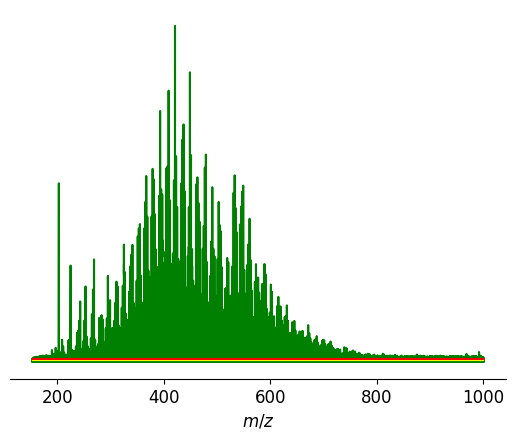

In [40]:
from corems.encapsulation.factory.parameters import MSParameters
from corems.transient.input.brukerSolarix import ReadBrukerSolarix

file_location = "../../tests/tests_data/ftms/ESI_NEG_SRFA.d"

# Set MS Parameters
MSParameters.transient.apodization_method = "Hanning"
MSParameters.transient.number_of_truncations = 0
MSParameters.transient.number_of_zero_fills = 1

MSParameters.mass_spectrum.noise_threshold_method = "relative_abundance"
MSParameters.mass_spectrum.noise_threshold_min_relative_abundance = 1
MSParameters.ms_peak.peak_min_prominence_percent = 1


def import_transient():
    with ReadBrukerSolarix(file_location) as bruker_transient:
        mass_spectrum = bruker_transient.get_mass_spectrum(
            plot_result=False, auto_process=True
        )

        mass_spectrum.plot_profile_and_noise_threshold()

        print("m/z count", len(mass_spectrum))

        print(
            "first m/z",
            mass_spectrum.mspeaks[0].mz_exp,
            "final m/z",
            mass_spectrum.mspeaks[-1].mz_exp,
        )

    return mass_spectrum


mass_spectrum = import_transient()

### 2. View Mass Spectrum Properties

After processing, we can examine the mass spectrum object and its properties.

In [41]:
# View basic statistics about the mass spectrum
print(f"Total number of peaks detected: {len(mass_spectrum)}")
print(f"m/z range: {mass_spectrum.min_mz_exp:.2f} - {mass_spectrum.max_mz_exp:.2f}")
print(f"Baseline noise: {mass_spectrum.baseline_noise:.2e}")
print(f"Baseline noise std: {mass_spectrum.baseline_noise_std:.2e}")
print(f"Number average molecular weight: {mass_spectrum.number_average_molecular_weight():.2f}")
print(f"Weight average molecular weight: {mass_spectrum.weight_average_molecular_weight():.2f}")

Total number of peaks detected: 10588
m/z range: 155.87 - 999.66
Baseline noise: 1.85e+05
Baseline noise std: 2.67e+05
Number average molecular weight: 462.34
Weight average molecular weight: 518.36


### 3. Examine Individual Peaks

We can iterate through peaks and examine their properties.

In [42]:
# Display information about the first few peaks
print("First 5 peaks:")
print(f"{'m/z':<12} {'Abundance':<15} {'Resolving Power':<18} {'S/N'}")
print("-" * 60)

for mspeak in mass_spectrum.mspeaks[:5]:
    print(f"{mspeak.mz_exp:<12.5f} {mspeak.abundance:<15.2e} {mspeak.resolving_power:<18.1f} {mspeak.signal_to_noise:.1f}")

First 5 peaks:
m/z          Abundance       Resolving Power    S/N
------------------------------------------------------------
155.87357    4.72e+05        516505.4           1.8
155.95415    4.64e+05        589986.1           1.7
156.78101    5.10e+05        1027031.2          1.9
156.81712    5.50e+05        821435.6           2.1
157.51695    4.60e+05        817786.0           1.7


### 4. Parameter Configuration

CoreMS provides flexible parameter configuration. You can modify parameters globally before processing or on individual mass spectrum objects.

In [43]:
kb = {'C': 1, 'H': 2}

print("m/z", "peak height", "resolving power", "S/N", "Kendrick Mass Defect", "Has Molecular Formula Obj")

for mspeak in mass_spectrum.sort_by_abundance():
    
    print(mspeak.mz_exp, mspeak.abundance, mspeak.resolving_power, 
          mspeak.signal_to_noise, mspeak.kmd, mspeak.is_assigned)
    
    mspeak.change_kendrick_base(kb)



m/z peak height resolving power S/N Kendrick Mass Defect Has Molecular Formula Obj
207.8829284071716 427525.793186123 774565.7177918004 1.618554264649943 -0.6508035171562767 False
171.77404666928626 427810.95168100233 937387.9678435413 1.636799610854837 -0.5822414450857707 False
171.17425150670846 428083.6343767398 752538.1743541526 1.6012691998242539 -0.9831160219002868 False
226.7983513181362 428230.4670857541 405694.4102089933 1.6085913453406917 -0.5451052110183525 False
245.59788422057045 428259.58865482075 655620.4679096205 1.6252762343043776 -0.3236463007012844 False
215.98880602542087 428645.53251130035 745496.9680014792 1.608471310168291 -0.7476300028039873 False
367.80432729399416 428663.2822404946 350227.37432724884 1.6197546163739491 -0.3936320066300709 False
194.23470028485866 430405.78690058657 473709.5530986071 1.614473068788322 -0.01781519099242246 False
176.4851165673338 432202.4808045315 912365.4678324227 1.6531243943013212 -0.28805089875569934 False
626.9767388428112 

### 4. How to change settings

In [44]:
# Option 1. Before Mass Spectrum Creation
from corems.encapsulation.factory.parameters import MSParameters

# Data input 
MSParameters.data_input.add_mz_label = 'moz'

# Transient
MSParameters.transient.number_of_zero_fills = 1

# Mass Spectrum 
MSParameters.mass_spectrum.min_calib_ppm_error = -1
MSParameters.mass_spectrum.max_calib_ppm_error = 1
MSParameters.mass_spectrum.noise_threshold_min_std = 2 

# Molecular Formula Search
MSParameters.molecular_search.max_dbe = 40
MSParameters.molecular_search.min_dbe = 10

# Mass Spectrum Peak Obj
MSParameters.ms_peak.kendrick_base = {'C':1, 'H':2}

# Option 2. After mass spectrum object is created you can manually change the settings inside the object:

# Mass Spectrum 
mass_spectrum.settings.do_calibration = True

# Molecular Formula Search
mass_spectrum.molecular_search_settings.error_method = 'None'
mass_spectrum.molecular_search_settings.min_ppm_error  = -1
mass_spectrum.molecular_search_settings.max_ppm_error = 1
mass_spectrum.molecular_search_settings.mz_error_range = 1

mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1,90)
mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4,200)
mass_spectrum.molecular_search_settings.usedAtoms['O'] = (0,20)
mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0,0)
mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0,0)

# Mass Spectrum Peak Obj
mass_spectrum.mspeaks_settings


MassSpecPeakSetting(kendrick_base={'C': 1, 'H': 2}, kendrick_rounding_method='floor', implemented_kendrick_rounding_methods=('floor', 'ceil', 'round'), peak_derivative_threshold=0.0, peak_min_prominence_percent=1.0, min_peak_datapoints=5.0, peak_max_prominence_percent=0.1, peak_height_max_percent=10.0, legacy_resolving_power=True, legacy_centroid_polyfit=False)

### 5. Mass Spectrum Calibration

Mass calibration improves accuracy by matching peaks to known reference masses. Here we'll use a reference file with known calibrant masses.

In [45]:
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

# Set calibration error thresholds
MSParameters.mass_spectrum.min_calib_ppm_error = -5
MSParameters.mass_spectrum.max_calib_ppm_error = 5

# Path to reference mass list for calibration
ref_file_location = '../../tests/tests_data/ftms/SRFA.ref'

# Perform calibration
calibration = MzDomainCalibration(mass_spectrum, ref_file_location)
calibration.run()

print("Calibration completed successfully")

MS Obj loaded - 10588 peaks found.
Reference mass list loaded - 60 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.792 ppm
minimize function performed 365 fn evals and 6 iterations
Calibration completed successfully


### 6. Molecular Formula Assignment

After calibration, we can search for molecular formulas that match our peaks. This requires setting search parameters and atom ranges.

**Note:** This step requires a molecular formula database. For full functionality, set up the PostgreSQL database as described in the CoreMS documentation, or use the built-in SQLite database by leaving `url_database` empty.

'runworker'  8.03 ms


Loading molecular formula database: 49637it [00:01, 29424.21it/s]
Started molecular formula search for class {"O": 20}, (de)protonated : 100%|██████████| 20/20 [00:00<00:00, 23.49it/s]


'run_molecular_formula'  2577.55 ms
1564 assigned peaks and 9024 unassigned peaks, total  = 14.77 %, relative abundance = 39.07 %, RMS error (best candidate) (ppm) = 0.541


<Axes: xlabel='$\t{m/z}$', ylabel='Abundance'>

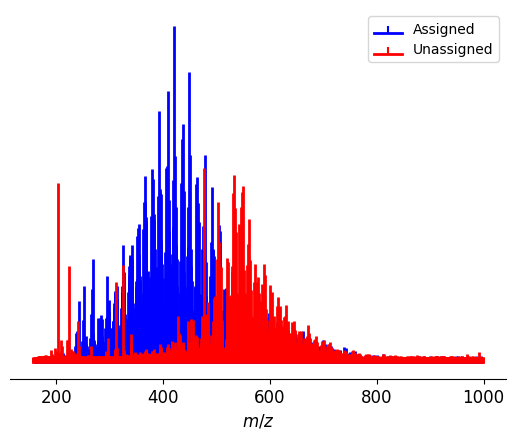

In [46]:
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.molecular_id.factory.classification import HeteroatomsClassification

# Configure molecular formula search parameters
# Leave url_database empty to use built-in SQLite database
mass_spectrum.molecular_search_settings.url_database = ""

# Set error tolerance
mass_spectrum.molecular_search_settings.error_method = 'None'
mass_spectrum.molecular_search_settings.min_ppm_error  = -1
mass_spectrum.molecular_search_settings.max_ppm_error = 1

# Set DBE (Double Bond Equivalent) range
mass_spectrum.molecular_search_settings.min_dbe = 0
mass_spectrum.molecular_search_settings.max_dbe = 50

# Set ionization mode
mass_spectrum.molecular_search_settings.isProtonated = True 
mass_spectrum.molecular_search_settings.isRadical = False 
mass_spectrum.molecular_search_settings.isAdduct = False

# Define allowed atoms and their ranges (min, max)
mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1, 90)
mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms['O'] = (1, 20)
mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0, 0)

# Run molecular formula search (first_hit=True for faster search, only best match per peak)
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

# Report assignment statistics
mass_spectrum.percentile_assigned(report_error=True)

# Plot assigned vs unassigned peaks
mass_spectrum_by_classes = HeteroatomsClassification(mass_spectrum, choose_molecular_formula=True)
mass_spectrum_by_classes.plot_ms_assigned_unassigned()


### 7. Accessing Molecular Formula Assignments

Once formulas are assigned, you can access them through the peak objects.

In [47]:
# Display assigned formulas for the first 5 peaks (sorted by abundance)
print("Top 5 peaks with assignments:")
print(f"{'abundance':<15} {'m/z':<12} {'Formula':<12} {'m/z_calc':<12} {'DBE':<6} {'Class':<10} ")
print("-" * 60)

j=0
for i, mspeak in enumerate(mass_spectrum.sort_by_abundance(reverse=True)):
    if mspeak.is_assigned and j < 5:  # Check if peak has formula assignment
        # Get the first (best) molecular formula for this peak
        mf = mspeak[0]
        print(f"{mspeak.abundance:<8f} {mspeak.mz_exp:<12.5f} {mf.string:<12} {mf.mz_calc:<12.5f} {mf.dbe:<6.1f} {mf.class_label:<10}")
        j += 1


Top 5 peaks with assignments:
abundance       m/z          Formula      m/z_calc     DBE    Class      
------------------------------------------------------------
40715248.872323 421.04136    C18 H14 O12  421.04125    12.0   O12       
35096854.483459 449.03631    C19 H14 O13  449.03616    13.0   O13       
32874501.575647 409.04123    C17 H14 O12  409.04125    11.0   O12       
30409082.169319 393.04643    C17 H14 O11  393.04633    11.0   O11       
28777187.978647 437.03630    C18 H14 O13  437.03616    12.0   O13       


In [48]:
# View analyzer type
print(f"Mass analyzer: {mass_spectrum.analyzer}")

Mass analyzer: ICR


### 8. Export Results

CoreMS supports multiple export formats for further analysis.

In [49]:
# Export to CSV (can be opened in Excel)
output_filename = "srfa_results"
mass_spectrum.to_csv(output_filename)
print(f"Results exported to {output_filename}.csv")

# Export to HDF5 format (preserves all data and metadata)
mass_spectrum.to_hdf(output_filename)
print(f"Results exported to {output_filename}.hdf5")

# Get results as pandas DataFrame for further analysis
df = mass_spectrum.to_dataframe()
print(f"\nDataFrame shape: {df.shape[0]} rows x {df.shape[1]} columns")

Results exported to srfa_results.csv
Results exported to srfa_results.hdf5

DataFrame shape: 10588 rows x 26 columns


In [50]:
# Display first few rows of the results
df.head()

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Heteroatom Class,Ion Type,Adduct,Is Isotopologue,Mono Isotopic Index,Molecular Formula,C,H,O,13C
0,17,161.097156,161.097255,161.097189,5.015108e+05,74.120584,799611.574215,1.909039,-1,0.409091,...,O1,de-protonated,NaN,0.0,NaN,C11 H14 O1,11.0,14.0,1.0,NaN
1,793,191.092680,191.092502,191.092497,4.756492e+05,60.985519,842622.467885,1.819733,-1,0.023213,...,O5,de-protonated,NaN,0.0,NaN,C8 H16 O5,8.0,16.0,5.0,NaN
2,1319,213.004603,213.004234,213.004076,1.133884e+06,413.725135,503960.311953,4.260768,-1,0.742070,...,O7,de-protonated,NaN,0.0,NaN,C8 H6 O7,8.0,6.0,7.0,NaN
3,1320,213.041032,213.040664,213.040462,8.952677e+05,257.869963,604649.174357,3.370108,-1,0.948519,...,O6,de-protonated,NaN,0.0,NaN,C9 H10 O6,9.0,10.0,6.0,NaN
4,1361,215.035472,215.035087,215.034982,6.310215e+05,96.654704,748801.968079,2.437194,-1,0.485565,...,O4,de-protonated,NaN,0.0,NaN,C12 H8 O4,12.0,8.0,4.0,NaN
